In [ ]:
from chara_uvcalc import uv_calc
from binary_disks_vector import binary_disks_vector
from read_oifits import read_chara,read_vlti
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
eachindex = lambda lst: range(len(lst))
from tqdm import tqdm
import os
import matplotlib.cm as cm
import time
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib as mpl
from matplotlib.patches import Ellipse
from ellipse_fitting import ellipse_hull_fit

%matplotlib inline

In [2]:
######################################################################
## DEFINE FITTING FUNCTIONS
######################################################################

## function which converts cartesian to polar coords
def cart2pol(x,y):
    x=-x
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y,x) * 180 / np.pi
    if theta>0 and theta<90:
        theta_new = theta+270
    if theta>90 and theta<360:
        theta_new = theta-90
    if theta<0:
        theta_new = 270+theta
    return(r,theta_new)

## function which returns complex vis given sep, pa, flux ratio, HA, dec, UD1, UD2, wavelength
def cvis_model(params, u, v, wl):
    sep = params['sep']
    pa = params['pa']
    ratio = params['ratio']
    ud1 = params['ud1']
    ud2 = params['ud2']
    bw = params['bw']  
    
    ul=np.array([u/i for i in wl])
    vl=np.array([v/i for i in wl])
    
    vis=binary_disks_vector().binary(ul,vl,sep,pa,ratio,ud1,ud2,bw)
    return vis

## same thing, but for triple
def triple_model(params, u, v, wl):  
    sep12 = params['sep12']
    pa12 = params['pa12']
    sep13 = params['sep13']
    pa13 = params['pa13']
    ratio12 = params['ratio12']
    ratio13 = params['ratio13']
    ud1 = params['ud1']
    ud2 = params['ud2']
    ud3 = params['ud3']  
    bw = params['bw']
    
    ul=np.array([u/i for i in wl])
    vl=np.array([v/i for i in wl])
    
    vis=binary_disks_vector().triple(ul,vl,sep12,pa12,sep13,pa13,ratio12,ratio13,ud1,ud2,ud3,bw)
    return vis

## function which returns residual of model and data to be minimized
def combined_minimizer(params,cp,cp_err,vphi,vphierr,v2,v2err,u_coord,v_coord,ucoord,vcoord,wl):

    diff=np.empty((0,len(wl)))

    if 'cphase' in flag:
        cp_model = []
        for item1,item2 in zip(u_coord,v_coord):
            complex_vis = cvis_model(params, item1, item2, wl)
            phase = np.angle(complex_vis[:,0])+np.angle(complex_vis[:,1])+np.angle(complex_vis[:,2])
            cp_model.append(phase)
        cp_model=np.array(cp_model)
        cp = cp*np.pi/180
        cp_err = cp_err*np.pi/180
        if absolute=='y':
            cp_diff = np.arctan2(np.sin(abs(cp)-abs(cp_model)),np.cos(abs(cp)-abs(cp_model)))/cp_err
        else:
            cp_diff = np.arctan2(np.sin(cp-cp_model),np.cos(cp-cp_model))/cp_err
        diff = np.append(diff,cp_diff,axis=0)

    if 'vis2' in flag:
        vis2_model = []
        for item1,item2 in zip(ucoord,vcoord):
            complex_vis2 = cvis_model(params,item1,item2,wl)
            visibility2 = complex_vis2*np.conj(complex_vis2)
            vis2_model.append(visibility2.real)
        vis2_model=np.array(vis2_model)
        vis2_diff = (v2 - vis2_model) / v2err
        diff = np.append(diff,vis2_diff,axis=0)

    if 'dphase' in flag:
        vis_model = []
        for item1,item2 in zip(ucoord,vcoord):
            complex_vis = cvis_model(params,item1,item2,wl)
            visibility = np.angle(complex_vis)
            if method=='dphase':
                dphase = visibility[1:]-visibility[:-1]
                dphase = np.insert(dphase,len(dphase),np.nan)
            else:
                dphase = visibility
            vis_model.append(dphase)
        vis_model=np.array(vis_model)
        vphi_data = vphi*np.pi/180
        vphi_err = vphierr*np.pi/180
        vphi_err[vphi_err==0]=100
        if absolute=='y':
            vphi_diff = np.arctan2(np.sin(abs(vphi_data)-abs(vis_model)),np.cos(abs(vphi_data)-abs(vis_model))) / vphi_err
        else:
            vphi_diff = np.arctan2(np.sin(vphi_data-vis_model),np.cos(vphi_data-vis_model)) / vphi_err
        vphi_diff = np.arctan2(np.sin(vphi_data-vis_model),np.cos(vphi_data-vis_model)) / vphi_err
        diff = np.append(diff,vphi_diff,axis=0)
    
    diff = np.array(diff)
    return diff

## for triple
## function which returns residual of model and data to be minimized
def triple_minimizer(params,cp,cp_err,vphi,vphierr,v2,v2err,u_coord,v_coord,ucoord,vcoord,wl):

    diff=np.empty((0,len(wl)))

    if 'cphase' in flag:
        cp_model = []
        for item1,item2 in zip(u_coord,v_coord):
            complex_vis = triple_model(params, item1, item2, wl)
            phase = np.angle(complex_vis[:,0])+np.angle(complex_vis[:,1])+np.angle(complex_vis[:,2])
            cp_model.append(phase)
        cp_model=np.array(cp_model)
        cp = cp*np.pi/180
        cp_err = cp_err*np.pi/180
        cp_diff = np.arctan2(np.sin(cp-cp_model),np.cos(cp-cp_model))/cp_err
        diff = np.append(diff,cp_diff,axis=0)

    if 'vis2' in flag:
        vis2_model = []
        for item1,item2 in zip(ucoord,vcoord):
            complex_vis2 = triple_model(params,item1,item2,wl)
            visibility2 = complex_vis2*np.conj(complex_vis2)
            vis2_model.append(visibility2.real)
        vis2_model=np.array(vis2_model)
        vis2_diff = (v2 - vis2_model) / v2err
        diff = np.append(diff,vis2_diff,axis=0)

    if 'dphase' in flag:
        vis_model = []
        for item1,item2 in zip(ucoord,vcoord):
            complex_vis = triple_model(params,item1,item2,wl)
            visibility = np.angle(complex_vis)
            if method=='dphase':
                dphase = visibility[1:]-visibility[:-1]
                dphase = np.insert(dphase,len(dphase),np.nan)
            else:
                dphase = visibility
            vis_model.append(dphase)
        vis_model=np.array(vis_model)
        vphi_data = vphi*np.pi/180
        vphi_err = vphierr*np.pi/180
        vphi_err[vphi_err==0]=100
        vphi_diff = np.arctan2(np.sin(vphi_data-vis_model),np.cos(vphi_data-vis_model)) / vphi_err
        diff = np.append(diff,vphi_diff,axis=0)
    
    diff = np.array(diff)
    return diff

In [3]:
######################################################################
## LOAD DATA
######################################################################
## Ask the user which file contains the closure phases
date='2019Jul30'
dir= '/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/'
target_id='HD_196867'
interact = 'n'
exclude = ''
absolute = ''

## get information from fits file
t3phi,t3phierr,vis2,vis2err,visphi,visphierr,visamp,visamperr,u_coords,v_coords,ucoords,vcoords,eff_wave,tels,vistels,time_obs = read_chara(dir,target_id,interact,exclude)

################################################
## Dispersion fit for dphase
################################################
dispersion=[]
for vis in visphi:
    if np.count_nonzero(~np.isnan(vis))>0:
        y=vis
        x=eff_wave[0]
        idx = np.isfinite(x) & np.isfinite(y)
        z=np.polyfit(x[idx],y[idx],2)
        p = np.poly1d(z)
        dispersion.append(p(x))
    else:
        dispersion.append(vis)
dispersion=np.array(dispersion)

## subtract dispersion
visphi_new = visphi-dispersion

/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00813_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00825_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00837_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00849_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00861_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00978_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx00990_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx01002_oifits_uvfix.fits
/Volumes/monnier-mini-raid48/PUBLIC/reduced/2019Jul30/oifits_ncoh10_60sec_uvfix/mircx01014_oifits_uvfix.fits
/Volumes/monnier-mi

In [4]:
visphi.shape

(150, 32)

In [5]:
method = 'dphase'
flag = 'cphase dphase'
reduction_params = '10 0 1 60 phases'

In [6]:
######################################################################
## DO A TRIPLE CHI2 FIT
######################################################################
params = Parameters()
params.add('sep12',   value= 128.08)
params.add('pa12', value= 295.63)
params.add('sep13',   value= 126.5)
params.add('pa13', value= 297)
params.add('ratio12', value= 10, min=1.0)
params.add('ratio13', value= 15, min=1.0)
params.add('ud1',   value= 0.5, vary=False)#min=0.0,max=2.0)
params.add('ud2', value= 0.5, vary=False)#min=0.0,max=2.0)
params.add('ud3', value= 0.5, vary=False)#min=0.0,max=2.0)
params.add('bw', value= 0.005, min=0,max=1)

minner = Minimizer(triple_minimizer, params, fcn_args=(t3phi,t3phierr,visphi_new,visphierr,vis2,vis2err,u_coords,v_coords,ucoords,vcoords,eff_wave[0]),nan_policy='omit')
result = minner.minimize()
report_fit(result)

chi_sq_best = result.redchi
sep12_best = result.params['sep12'].value
pa12_best = result.params['pa12'].value
sep13_best = result.params['sep13'].value
pa13_best = result.params['pa13'].value
ratio12_best = result.params['ratio12'].value
ratio13_best = result.params['ratio13'].value
ud1_best = result.params['ud1'].value
ud2_best = result.params['ud2'].value
ud3_best = result.params['ud3'].value
bw_best = result.params['bw'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 11050
    # variables        = 7
    chi-square         = 44279.1962
    reduced chi-square = 4.00970717
    Akaike info crit   = 15352.3340
    Bayesian info crit = 15403.5053
[[Variables]]
    sep12:    128.079983 +/- 0.00121884 (0.00%) (init = 128.08)
    pa12:     295.627047 +/- 4.4491e-04 (0.00%) (init = 295.63)
    sep13:    126.485644 +/- 0.00151493 (0.00%) (init = 126.5)
    pa13:     297.022736 +/- 5.5162e-04 (0.00%) (init = 297)
    ratio12:  10.3810316 +/- 0.03871629 (0.37%) (init = 10)
    ratio13:  12.8154391 +/- 0.05529654 (0.43%) (init = 15)
    ud1:      0.5 (fixed)
    ud2:      0.5 (fixed)
    ud3:      0.5 (fixed)
    bw:       0.00647728 +/- 3.3749e-05 (0.52%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(ratio12, bw)      = -0.617
    C(ratio13, bw)      = -0.549
    C(ratio12, ratio13) =  0.396
    C(sep12, pa12)      =  0.284
    

In [7]:
######################################################################
## DO A BINARY FIT
######################################################################
params = Parameters()
params.add('sep',   value= 128.08)
params.add('pa', value= 295.63)
params.add('ratio', value= 10, min=1.0)
params.add('ud1',   value= 0.5, vary=False)#min=0.0,max=2.0)
params.add('ud2', value= 0.5, vary=False)#min=0.0,max=2.0)
params.add('bw', value=0.005)

minner = Minimizer(combined_minimizer, params, fcn_args=(t3phi,t3phierr,visphi_new,visphierr,vis2,vis2err,u_coords,v_coords,ucoords,vcoords,eff_wave[0]),nan_policy='omit')
result = minner.minimize()
report_fit(result)

chi_sq_best = result.redchi
sep_best = result.params['sep'].value
pa_best = result.params['pa'].value
ratio_best = result.params['ratio'].value
bw_binary_best = result.params['bw'].value

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 11050
    # variables        = 4
    chi-square         = 349202.257
    reduced chi-square = 31.6134580
    Akaike info crit   = 38166.0905
    Bayesian info crit = 38195.3312
[[Variables]]
    sep:    128.127223 +/- 0.00332948 (0.00%) (init = 128.08)
    pa:     295.647828 +/- 0.00133933 (0.00%) (init = 295.63)
    ratio:  12.1890064 +/- 0.15229444 (1.25%) (init = 10)
    ud1:    0.5 (fixed)
    ud2:    0.5 (fixed)
    bw:     0.00472808 +/- 1.8065e-04 (3.82%) (init = 0.005)
[[Correlations]] (unreported correlations are < 0.100)
    C(ratio, bw) = -0.729
    C(sep, pa)   =  0.323


In [8]:
######################################################################
## FORM MODEL FROM BEST FIT PARAMS TO PLOT AGAINST DATA
######################################################################
best_params = Parameters()
best_params.add('sep12',   value= sep12_best)
best_params.add('pa12', value= pa12_best)
best_params.add('sep13',   value= sep13_best)
best_params.add('pa13', value= pa13_best)
best_params.add('ratio12', value= ratio12_best)
best_params.add('ratio13', value= ratio13_best)
best_params.add('ud1',   value= ud1_best)
best_params.add('ud2', value= ud2_best)
best_params.add('ud3', value= ud3_best)
best_params.add('bw', value=bw_best)

cp_model_triple = []
for item1,item2 in zip(u_coords,v_coords):
    complex_vis = triple_model(best_params, item1, item2, eff_wave[0])
    phase = (np.angle(complex_vis[:,0])+np.angle(complex_vis[:,1])+np.angle(complex_vis[:,2]))*180/np.pi
    cp_model_triple.append(phase)
cp_model_triple=np.array(cp_model_triple)

visphi_model_triple = []
for item1,item2 in zip(ucoords,vcoords):     
    complex_vis = triple_model(best_params,item1, item2, eff_wave[0])
    visibility = np.angle(complex_vis)*180/np.pi
    if method=='dphase':
        dphase = visibility[1:]-visibility[:-1]
        dphase = np.insert(dphase,len(dphase),np.nan)
    else:
        dphase = visibility
    visphi_model_triple.append(dphase)
visphi_model_triple=np.array(visphi_model_triple)

vis2_model_triple = []
for item1,item2 in zip(ucoords,vcoords):
    complex_vis2 = triple_model(best_params,item1,item2,eff_wave[0])
    visibility2 = complex_vis2*np.conj(complex_vis2)
    vis2_model_triple.append(visibility2.real)
vis2_model_triple=np.array(vis2_model_triple)

In [9]:
######################################################################
## FORM MODEL FROM BEST FIT PARAMS TO PLOT AGAINST DATA
######################################################################
best_params = Parameters()
best_params.add('sep',   value= sep_best)
best_params.add('pa', value= pa_best)
best_params.add('ratio', value= ratio_best)
best_params.add('ud1',   value= ud1_best)
best_params.add('ud2', value= ud2_best)
best_params.add('bw', value=bw_binary_best)

cp_model_binary = []
for item1,item2 in zip(u_coords,v_coords):
    complex_vis = cvis_model(best_params, item1, item2, eff_wave[0])
    phase = (np.angle(complex_vis[:,0])+np.angle(complex_vis[:,1])+np.angle(complex_vis[:,2]))*180/np.pi
    cp_model_binary.append(phase)
cp_model_binary=np.array(cp_model_binary)

visphi_model_binary = []
for item1,item2 in zip(ucoords,vcoords):     
    complex_vis = cvis_model(best_params,item1, item2, eff_wave[0])
    visibility = np.angle(complex_vis)*180/np.pi
    if method=='dphase':
        dphase = visibility[1:]-visibility[:-1]
        dphase = np.insert(dphase,len(dphase),np.nan)
    else:
        dphase = visibility
    visphi_model_binary.append(dphase)
visphi_model_binary=np.array(visphi_model_binary)

vis2_model_binary = []
for item1,item2 in zip(ucoords,vcoords):
    complex_vis2 = cvis_model(best_params,item1,item2,eff_wave[0])
    visibility2 = complex_vis2*np.conj(complex_vis2)
    vis2_model_binary.append(visibility2.real)
vis2_model_binary=np.array(vis2_model_binary)

In [10]:
## regroup data by measurements
n_cp = len(t3phi)/20
n_vp = len(visphi)/15
n_v2 = len(vis2)/15
t3phi_plot = np.array(np.array_split(t3phi,n_cp))
t3phierr_plot = np.array(np.array_split(t3phierr,n_cp))
cp_model_triple = np.array_split(cp_model_triple,n_cp)
cp_model_binary = np.array_split(cp_model_binary,n_cp)
visphi_new_plot = np.array_split(visphi_new,n_vp)
visphierr_plot = np.array_split(visphierr,n_vp)
visphi_model_triple = np.array_split(visphi_model_triple,n_vp)
visphi_model_binary = np.array_split(visphi_model_binary,n_vp)

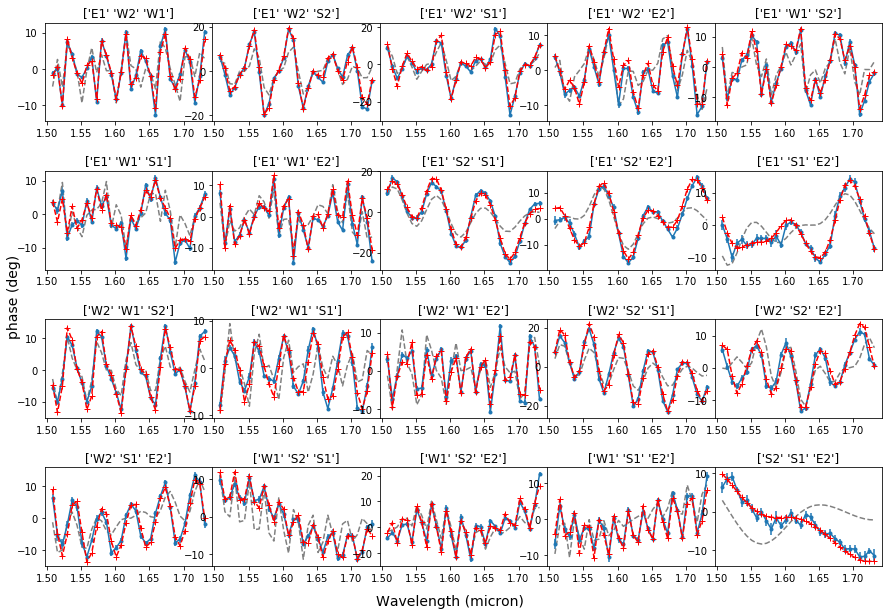

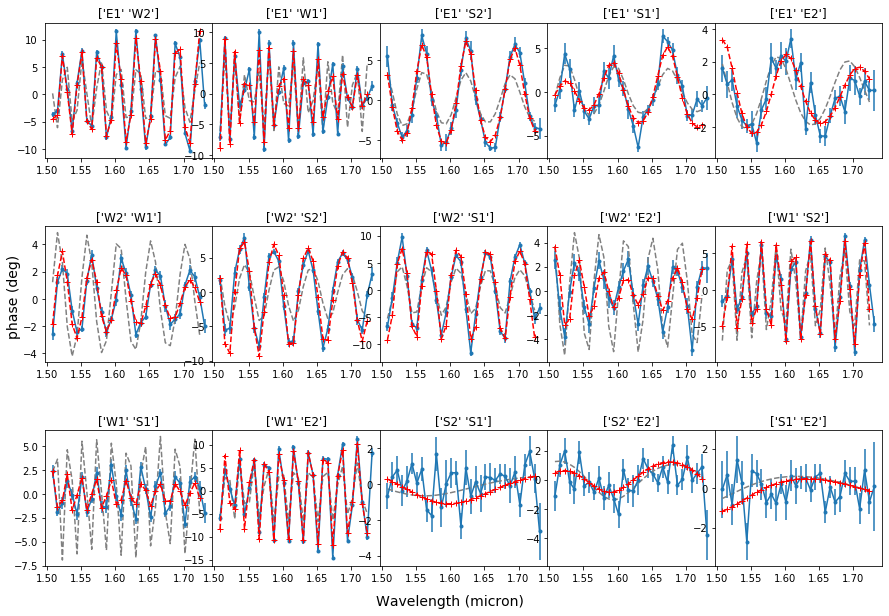

In [14]:
## next pages - cp model fits
index = np.linspace(0,19,20)

t3data = t3phi_plot[1]
t3errdata = t3phierr_plot[1]
modeldata_triple = cp_model_triple[1]
modeldata_binary = cp_model_binary[1]
    
label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(4,5,figsize=(15,10),facecolor='w',edgecolor='k')
fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind,y,yerr,mt,mb,tri in zip(index,t3data,t3errdata,modeldata_triple,modeldata_binary,tels[:20]):
    x=eff_wave[0]*1e6
    axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-',zorder=1)
    axs[int(ind)].plot(x,mt,'+--',color='r',zorder=2)
    axs[int(ind)].plot(x,mb,'--',color='grey',zorder=1)
    axs[int(ind)].set_title(str(tri))

#fig.suptitle('%s Closure Phase'%target_id)
fig.text(0.5, 0.07, 'Wavelength (micron)', ha='center', size=14)
fig.text(0.09, 0.5, 'phase (deg)', va='center', rotation='vertical', size=14)
plt.savefig('/Users/tgardne/ARMADA_epochs/HD_196867/HD196867_example_cp.pdf')
plt.show()

## next pages - visphi fits
index = np.linspace(0,14,15)
visdata = visphi_new_plot[1]
viserrdata = visphierr_plot[1]
modeldata_triple = visphi_model_triple[1]
modeldata_binary = visphi_model_binary[1]

label_size = 10
mpl.rcParams['xtick.labelsize'] = label_size
mpl.rcParams['ytick.labelsize'] = label_size

fig,axs = plt.subplots(3,5,figsize=(15,10),facecolor='w',edgecolor='k')
fig.subplots_adjust(hspace=0.5,wspace=.001)
axs=axs.ravel()

for ind,y,yerr,mt,mb,tri in zip(index,visdata,viserrdata,modeldata_triple,modeldata_binary,vistels[:15]):
    x=eff_wave[0]*1e6
    axs[int(ind)].errorbar(x,y,yerr=yerr,fmt='.-',zorder=1)
    axs[int(ind)].plot(x,mt,'+--',color='r',zorder=2)
    axs[int(ind)].plot(x,mb,'--',color='grey',zorder=1)
    axs[int(ind)].set_title(str(tri))

#fig.suptitle('%s VisPhi'%target_id)
fig.text(0.5, 0.07, 'Wavelength (micron)', ha='center', size=14)
fig.text(0.09, 0.5, 'phase (deg)', va='center', rotation='vertical', size=14)
plt.savefig('/Users/tgardne/ARMADA_epochs/HD_196867/HD196867_example_visphi.pdf')
plt.show()